Ming Li

ming.li2@columbia.edu

# Initialize the playground

## Clone the git repo

In [0]:
# this git repo contains all the functions and modules needed for this demo notebook
! git clone https://github.com/leemingee/GBCancerImage.git

## Download the source data

Download the source data using download_dataset.sh for this project. It will create two tif in the root directory

In [0]:
# Run the script to download the data, 091 is the pic num
! chmod +x download_dataset.sh
# ! ./download_dataset.sh 091

## Install the openslide on this colab VM

In [0]:
# Install the OpenSlide C library and Python bindings
!apt-get -qq install openslide-tools
!pip install --quiet openslide-python

## Valid tif and openslide

In [0]:
slide_path_091 = 'tumor_091.tif'
tumor_mask_path_091 = 'tumor_091_mask.tif'
slide_091 = open_slide(slide_path_091)
print ("Read WSI from %s with width: %d, height: %d" % (slide_path_091, 
                                                        slide_091.level_dimensions[0][0], 
                                                        slide_091.level_dimensions[0][1]))

tumor_mask_091 = open_slide(tumor_mask_path_091)
print ("Read tumor mask from %s" % (tumor_mask_path_091))

print("Slide includes %d levels" % len(slide_091.level_dimensions))
for i in range(len(slide_091.level_dimensions)):
    print("Level %d, dimensions: %s downsample factor %d" % (i, 
                                                             slide_091.level_dimensions[i], 
                                                             slide_091.level_downsamples[i]))
    assert tumor_mask_091.level_dimensions[i][0] == slide_091.level_dimensions[i][0]
    assert tumor_mask_091.level_dimensions[i][1] == slide_091.level_dimensions[i][1]

width, height = slide_091.level_dimensions[7]
assert width * slide_091.level_downsamples[7] == slide_091.level_dimensions[0][0]
assert height * slide_091.level_downsamples[7] == slide_091.level_dimensions[0][1]

Read WSI from tumor_091.tif with width: 61440, height: 53760
Read tumor mask from tumor_091_mask.tif
Slide includes 8 levels
Level 0, dimensions: (61440, 53760) downsample factor 1
Level 1, dimensions: (30720, 26880) downsample factor 2
Level 2, dimensions: (15360, 13440) downsample factor 4
Level 3, dimensions: (7680, 6720) downsample factor 8
Level 4, dimensions: (3840, 3360) downsample factor 16
Level 5, dimensions: (1920, 1680) downsample factor 32
Level 6, dimensions: (960, 840) downsample factor 64
Level 7, dimensions: (480, 420) downsample factor 128


## Well, good to go!

# Main Function

In [0]:
import logging
# todo add logging module to this program
import argparse
import os
import time
from utils import valid_openslide_data, sliding_train_data, process_slided_img_to_tf
from utils import plot_from_history, process_test_slided_data_to_tf, recover_2dimg_from_predictions
from module import *
import matplotlib.pyplot as plt
# use this to make sure it works with 
import sys; sys.argv=['']; del sys

parser = argparse.ArgumentParser(description='')
parser.add_argument('--slide_path_091', dest='slide_path_091', default='tumor_091.tif', help='The img used for modelling')
parser.add_argument('--tumor_mask_path_091', dest='tumor_mask_path_091', default='tumor_091_mask.tif', help='The img used for modelling')
parser.add_argument('--dataset_dir', dest='dataset_dir', default="/content/data/091/", help='path of the dataset')
parser.add_argument('--levelNO', dest='levelNO', type = int, default=3, help='level from 1 to 8')
parser.add_argument('--num_pixels', dest='num_pixels', type = int,  default=64, help='the length of sliding square')
parser.add_argument('--batch_size', dest='BATCH_SIZE', type = int,  default=32, help='# images in batch')
parser.add_argument('--epoch', dest='epoch', type=int, default=8, help='# of epoch')
parser.add_argument('--base_model', dest='base_model_name', default='VGG16', help='name of base model')
parser.add_argument('--build_shape', dest='build_shape', default=tf.TensorShape([None, 128, 128, 3]), help='build shape for VGG16 based model')
parser.add_argument('--period', dest='period', type=int, default=5, help='save a model every period epochs')
parser.add_argument('--level_num_test', dest='level_num_test', type=int, default=4, help='level from 1 to 8')

parser.add_argument('--lr', dest='lr', type=float, default=0.0002, help='initial learning rate for adam')

parser.add_argument('--phase', dest='phase', default='test', help='train, test')
parser.add_argument('--continue_train', dest='continue_train', type=bool, default=False, help='if continue training, load the latest model: 1: true, 0: false')
parser.add_argument('--checkpoint_dir', dest='checkpoint_dir', default='./checkpoint', help='models are saved here')
parser.add_argument('--sample_dir', dest='sample_dir', default='./sample', help='sample are saved here')
parser.add_argument('--test_dir', dest='test_dir', default='./test', help='test sample are saved here')
parser.add_argument('--L1_lambda', dest='L1_lambda', type=float, default=10.0, help='weight on L1 term in objective')


args = parser.parse_args()


def main():

    # check and create test and checkpoint folders
    if not os.path.exists(args.checkpoint_dir):
        os.makedirs(args.checkpoint_dir)
    if not os.path.exists(args.test_dir):
        os.makedirs(args.test_dir)


    # check the dataset exist
    if not os.path.exists(args.slide_path_091):
        print('please run the download_dataset.sh to download the dataset')
    else:
        pass



    if args.phase == 'train':

        # check the slided dataset dir exist
        if not os.path.exists(args.dataset_dir):
            print('Begin training data segmentation:')
            start_time = time.time()
            level_shape_dict = valid_openslide_data(slide_path=args.slide_path_091,
                                 tumor_mask_path=args.tumor_mask_path_091)
            _, _ = sliding_train_data(slide_path=args.slide_path_091, tumor_mask_path=args.tumor_mask_path_091, levelNO=args.levelNO,num_pixels=args.num_pixels)
            print('time taken for sliding the training data:', time.time() - start_time)
        else:
            print('data folder already exists')

        # get the training data from slided directory
        ds_091_L3, img_count = process_slided_img_to_tf(dataset_dir=args.dataset_dir, levelNO=args.levelNO, batch_size=args.BATCH_SIZE)
        # print('process slided imgs to tf input data. done!')

        model1 = create_model()
        history, model = train_model(args, model1, ds_091_L3, img_count)
        plot_from_history(history)

    else:
        print('reload the latest model from checkpoint')
        model_test = restore_model_from_latest_ckpt(args)
        print('generating test data from level', args.level_num_test)
        if not os.path.exists(args.dataset_dir + str(args.level_num_test)):
            shape0, shape1 = sliding_train_data(slide_path=args.slide_path_091, tumor_mask_path=args.tumor_mask_path_091,\
                                                levelNO=args.levelNO, num_pixels=args.num_pixels)
        ds_test, img_count_test = process_test_slided_data_to_tf(dataset_dir = args.dataset_dir, \
                                                                 level_num_test = args.level_num_test, BATCH_SIZE = 32)
        try:
            predictions = model_test.predict(ds_test, steps=int(np.ceil(img_count_test / 32)))
        except Exception as e:
            # print('e')
            print('predict done')

        prob_2d, pred_2d = recover_2dimg_from_predictions(args, predictions)
        visualize_pred_comparsion(prob_2d, pred_2d, mask_image_091_L3, tissue_regions_091_L3)
        evaluate_result(pred_2d, tissue_regions_091_L3, mask_image_091_L3)

if __name__ == "__main__":
    main()

## Train

data folder already exists
58892288/58889256 [==============================] - 1s 0us/step
Epoch 1/20
17/17 [==============================] - 17s 1s/step - loss: 0.5461 - acc: 0.7500
Epoch 2/20
17/17 [==============================] - 6s 347ms/step - loss: 0.4104 - acc: 0.8217
Epoch 3/20
17/17 [==============================] - 6s 346ms/step - loss: 0.3710 - acc: 0.8382
Epoch 4/20
17/17 [==============================] - 6s 347ms/step - loss: 0.3261 - acc: 0.8695
Epoch 5/20
16/17 [===========================>..] - ETA: 0s - loss: 0.3357 - acc: 0.8438
Epoch 00005: saving model to ./checkpoint/cp-0005.ckpt
17/17 [==============================] - 6s 358ms/step - loss: 0.3322 - acc: 0.8456
Epoch 6/20
17/17 [==============================] - 6s 348ms/step - loss: 0.3248 - acc: 0.8603
Epoch 7/20
17/17 [==============================] - 6s 348ms/step - loss: 0.2703 - acc: 0.9007
Epoch 8/20
17/17 [==============================] - 6s 348ms/step - loss: 0.2554 - acc: 0.8934
Epoch 9/20
17/17 

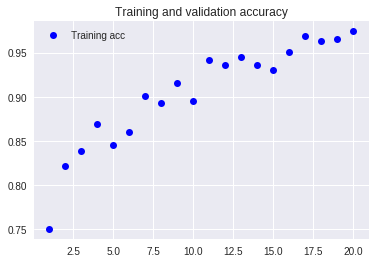

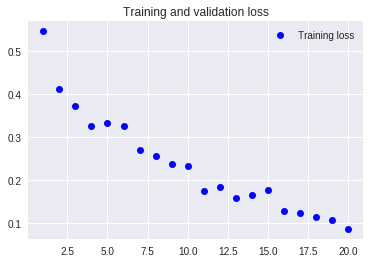

In [0]:
# Train the model
! python main.py --phase train

## test and valid the image091

Precision: 0.40658037278177506
Recall: 0.9718482067383166
F1: 0.5733113953869599
AUC score: 0.944956656125947


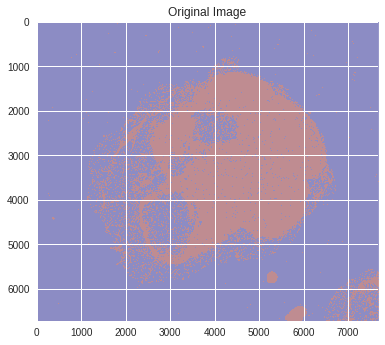

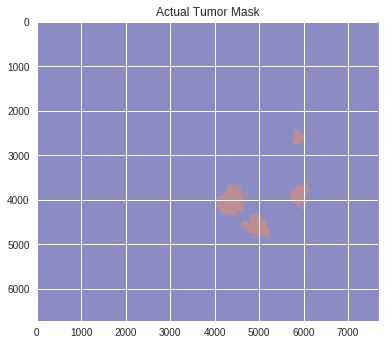

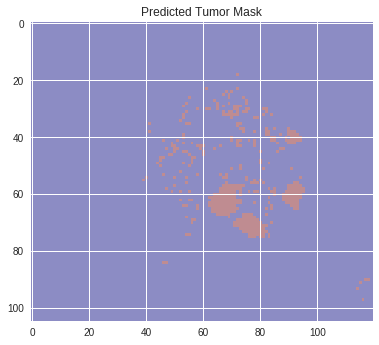

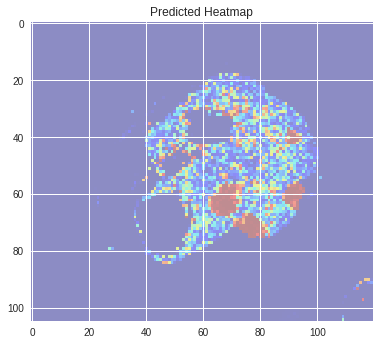

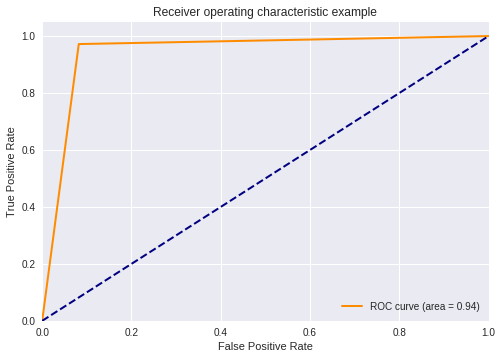

Confusion Matrix:
           Predicted 0  Predicted 1
Reality 0     11582011      1033664
Reality 1        20515       708213
           Predicted 0  Predicted 1
Reality 0    86.793025     7.746049
Reality 1     0.153735     5.307191


In [0]:
# Train the model using the same image
! python main.py --phase train

## Test using another image 110

In [0]:
! ./download_dataset.sh 110

Precision: 0.7391264563111515
Recall: 0.4678093730445379
F1: 0.5472097943331615
AUC score: 0.7135673237414428


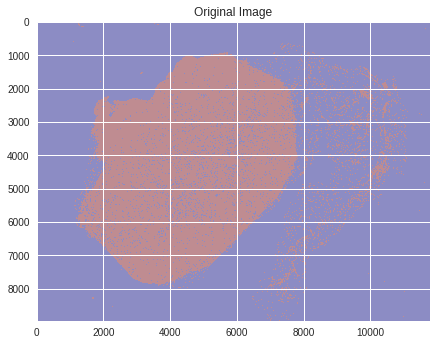

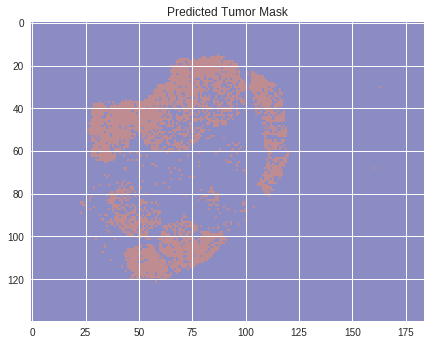

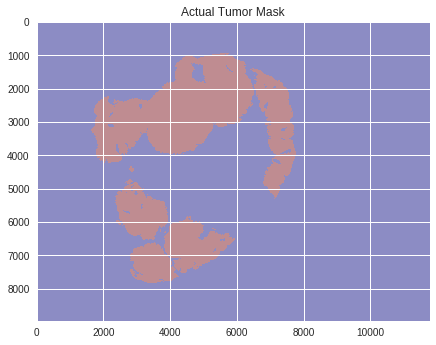

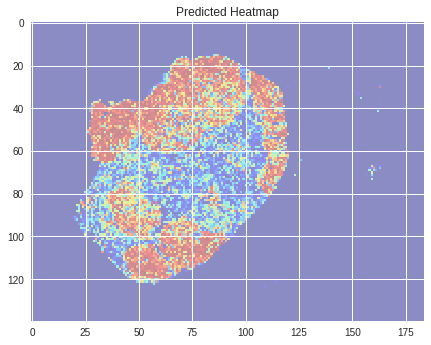

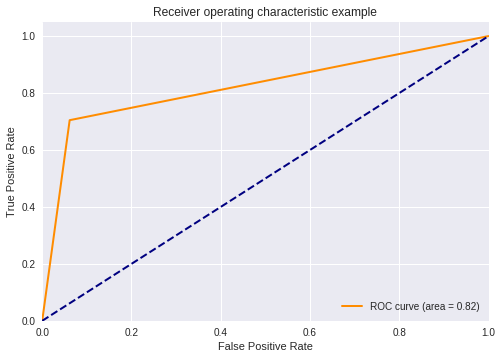

Confusion Matrix:
           Predicted 0  Predicted 1
Reality 0     15466503      1014073
Reality 1      4615116     11006826
           Predicted 0  Predicted 1
Reality 0    48.178473     3.158858
Reality 1    14.376181    34.286488


In [5]:
%%bash
python main.py --phase test --slide_path_091 tumor_110 
                --tumor_mask_path_091 tumor_110_mask
                --dataset_dir = /content/data/110/

# Appendix

## utils

In [0]:
'''
utils functions for GBCancerImage

Ming Li @ 12/10/18
'''

import matplotlib.pyplot as plt
import numpy as np
# from openslide import open_slide, __library_version__ as openslide_version
import os
from PIL import Image
from skimage.color import rgb2gray
import tensorflow as tf


'''
================ data processing ==============

This is the data processing functions used in the GBCancer Image
Part of the work credit to our professor Joshua and 
part of work credit to Terence Conlon (https://github.com/tconlon/camelyon-ai)
specially the sliding function can be tricky in math, Terence's robust work helps a lot!
'''
def LoadImage(path):
    image = tf.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize_images(image, [128, 128])
    image /= 255.0
    return image

def read_slide(slide, x, y, level, width, height, as_float=False):
    '''

    # See https://openslide.org/api/python/#openslide.OpenSlide.read_region
    # Note: x,y coords are with respect to level 0.
    # There is an example below of working with coordinates
    # with respect to a higher zoom level.

    # Read a region from the slide
    # Return a numpy RBG array

    '''
    im = slide.read_region((x,y), level, (width, height))
    im = im.convert('RGB') # drop the alpha channel
    if as_float:
        im = np.asarray(im, dtype=np.float32)
    else:
        im = np.asarray(im)
    assert im.shape == (height, width, 3)
    return im

def find_tissue_pixels(image, intensity=0.8):
    '''
    #As mentioned in class, we can improve efficiency by ignoring non-tissue areas
    of the slide. We'll find these by looking for all gray regions.

    '''
    im_gray = rgb2gray(image)
    assert im_gray.shape == (image.shape[0], image.shape[1])
    indices = np.where(im_gray <= intensity)
    return zip(indices[0], indices[1])

def apply_mask(im, mask, color=(255,0,0)):
    masked = np.copy(im)
    for x,y in mask: masked[x][y] = color
    return masked


def create_folder(slide_path, level, mode='train'):
    BASE_DIR = os.getcwd()

    img_num = slide_path.split('_')[1].strip(".tif")

    DATA = 'data/'
    IMG_NUM_FOLDER = img_num + '/'
    LEVEL_FOLDER = str(level) + '/'

    DATA_DIR = os.path.join(BASE_DIR, DATA)
    IMG_NUM_DIR = os.path.join(BASE_DIR, DATA, IMG_NUM_FOLDER)
    IMG_NUM_LEVEL_DIR = os.path.join(BASE_DIR, DATA, IMG_NUM_FOLDER, LEVEL_FOLDER)

    if not os.path.exists(DATA_DIR):
        os.mkdir(DATA_DIR)
    if not os.path.exists(IMG_NUM_DIR):
        os.mkdir(IMG_NUM_DIR)
    if not os.path.exists(IMG_NUM_LEVEL_DIR):
        os.mkdir(IMG_NUM_LEVEL_DIR)

    if mode == 'train':
        TUMOR_FOLDER = 'tumor/'
        NO_TUMOR_FOLDER = 'no_tumor/'
        TUMOR_DIR = os.path.join(BASE_DIR, DATA, IMG_NUM_FOLDER, LEVEL_FOLDER, TUMOR_FOLDER)
        NO_TUMOR_DIR = os.path.join(BASE_DIR, DATA, IMG_NUM_FOLDER, LEVEL_FOLDER, NO_TUMOR_FOLDER)
        if not os.path.exists(TUMOR_DIR):
            os.mkdir(TUMOR_DIR)
        if not os.path.exists(NO_TUMOR_DIR):
            os.mkdir(NO_TUMOR_DIR)
        return DATA + IMG_NUM_FOLDER + LEVEL_FOLDER + TUMOR_FOLDER, DATA + IMG_NUM_FOLDER + LEVEL_FOLDER + NO_TUMOR_FOLDER

    if mode == 'test':
        TISSUE_FOLDER = 'tissue_only/'
        ALL_FOLDER = 'all/'
        TISSUE_DIR = os.path.join(BASE_DIR, DATA, IMG_NUM_FOLDER, LEVEL_FOLDER, TISSUE_FOLDER)
        ALL_DIR = os.path.join(BASE_DIR, DATA, IMG_NUM_FOLDER, LEVEL_FOLDER, ALL_FOLDER)
        if not os.path.exists(TISSUE_DIR):
            os.mkdir(TISSUE_DIR)
        if not os.path.exists(ALL_DIR):
            os.mkdir(ALL_DIR)
        return DATA + IMG_NUM_FOLDER + LEVEL_FOLDER + TISSUE_FOLDER, DATA + IMG_NUM_FOLDER + LEVEL_FOLDER + ALL_FOLDER


def save_test_data(im, tissue_mask, num_pixels, level_num, slide_path):
    x, y = im.shape[0], im.shape[1]
    x_count, y_count = int(np.ceil(x / num_pixels)), int(np.ceil(y / num_pixels))
    tissue_folder, all_folder = create_folder(slide_path, level_num, mode='test')
    try:
        for i in range(x_count):
            for j in range(y_count):
                im_slice = np.zeros((num_pixels, num_pixels, 3))
                im_tissue_slice = np.zeros((num_pixels, num_pixels, 3))
                tissue_mask_slice = np.zeros((num_pixels, num_pixels))
                string_name = 'img_level%d_' % (level_num) + str(i * y_count + j)

                if i == x_count - 1:
                    ub_x = x
                    assign_x = x - (x_count - 1) * num_pixels
                else:
                    ub_x = (i + 1) * num_pixels
                    assign_x = num_pixels

                if j == y_count - 1:
                    ub_y = y
                    assign_y = y - (y_count - 1) * num_pixels
                else:
                    ub_y = (j + 1) * num_pixels
                    assign_y = num_pixels

                tissue_mask_slice[0:assign_x, 0:assign_y] = tissue_mask[(i * num_pixels):ub_x, (j * num_pixels):ub_y]

                try:
                    if np.mean(tissue_mask_slice) > 0.7:
                        im_tissue_slice[0:assign_x, 0:assign_y, :] = im[(i * num_pixels):ub_x, (j * num_pixels):ub_y, :]
                        im_file_name_tissue = tissue_folder + string_name + ".jpg"
                        cv2.imwrite(im_file_name_tissue, im_tissue_slice)
                    im_slice[0:assign_x, 0:assign_y, :] = im[(i * num_pixels):ub_x, (j * num_pixels):ub_y, :]
                    im_file_name_all = all_folder + string_name + ".jpg"
                    cv2.imwrite(im_file_name_all, im_slice)
                except Exception as oerr:
                    print('Error with saving:', oerr)
    except Exception as oerr:
        print('Error with slicing:', oerr)


def save_training_data(im, tumor_mask, tissue_mask, num_pixels, level, slide_path):
    '''
    sliding the training data and save slide by slide

    :param im: the level extracted image from original tif pic
    :param tumor_mask: the level extracted image from original tif mask pic
    :param tissue_mask: the level extracted tissue binary pic from original tif pic
    :param num_pixels: the length of sliding square
    :param level: levelNO
    :param slide_path: slide pic name, which is used in path here, to feed the create_folder
    :return: void function, store all the pics
    '''
    x, y = im.shape[0], im.shape[1]
    x_count, y_count = int(np.ceil(x / num_pixels)), int(np.ceil(y / num_pixels))
    tumor_folder, no_tumor_folder = create_folder(slide_path, level)
    try:
        for i in range(x_count):
            for j in range(y_count):
                im_slice = np.zeros((num_pixels, num_pixels, 3))
                tissue_mask_slice = np.zeros((num_pixels, num_pixels))
                tumor_mask_slice = np.zeros((num_pixels, num_pixels))
                string_name = 'img_level%d_' % (level) + str(i * y_count + j)

                if i == x_count - 1:
                    ub_x = x
                    assign_x = x - (x_count - 1) * num_pixels
                else:
                    ub_x = (i + 1) * num_pixels
                    assign_x = num_pixels

                if j == y_count - 1:
                    ub_y = y
                    assign_y = y - (y_count - 1) * num_pixels
                else:
                    ub_y = (j + 1) * num_pixels
                    assign_y = num_pixels

                tissue_mask_slice[0:assign_x, 0:assign_y] = tissue_mask[(i * num_pixels):ub_x, (j * num_pixels):ub_y]
                try:
                    if np.mean(tissue_mask_slice) > 0.7:
                        im_slice[0:assign_x, 0:assign_y, :] = im[(i * num_pixels):ub_x, (j * num_pixels):ub_y, :]
                        tumor_mask_slice[0:assign_x, 0:assign_y] = tumor_mask[(i * num_pixels):ub_x,
                                                                   (j * num_pixels):ub_y]

                        if np.max(tumor_mask_slice) > 0:
                            im_file_name = tumor_folder + string_name + ".jpg"
                        else:
                            im_file_name = no_tumor_folder + string_name + ".jpg"

                        cv2.imwrite(im_file_name, im_slice)
                except Exception as oerr:
                    print('Error with saving:', oerr)
    except Exception as oerr:
        print('Error with slicing:', oerr)


def save_test_data(im, tissue_mask, num_pixels, level_num, slide_path):
    x, y = im.shape[0], im.shape[1]
    x_count, y_count = int(np.ceil(x / num_pixels)), int(np.ceil(y / num_pixels))
    tissue_folder, all_folder = create_folder(slide_path, level=level_num, mode='test')
    try:
        for i in range(x_count):
            for j in range(y_count):
                im_slice = np.zeros((num_pixels, num_pixels, 3))
                im_tissue_slice = np.zeros((num_pixels, num_pixels, 3))
                tissue_mask_slice = np.zeros((num_pixels, num_pixels))
                string_name = 'img_level%d_' % (level_num) + str(i * y_count + j)

                if i == x_count - 1:
                    ub_x = x
                    assign_x = x - (x_count - 1) * num_pixels
                else:
                    ub_x = (i + 1) * num_pixels
                    assign_x = num_pixels

                if j == y_count - 1:
                    ub_y = y
                    assign_y = y - (y_count - 1) * num_pixels
                else:
                    ub_y = (j + 1) * num_pixels
                    assign_y = num_pixels

                tissue_mask_slice[0:assign_x, 0:assign_y] = tissue_mask[(i * num_pixels):ub_x, (j * num_pixels):ub_y]

                try:
                    if np.mean(tissue_mask_slice) > 0.7:
                        im_tissue_slice[0:assign_x, 0:assign_y, :] = im[(i * num_pixels):ub_x, (j * num_pixels):ub_y, :]
                        im_file_name_tissue = tissue_folder + string_name + ".jpg"
                        cv2.imwrite(im_file_name_tissue, im_tissue_slice)
                    im_slice[0:assign_x, 0:assign_y, :] = im[(i * num_pixels):ub_x, (j * num_pixels):ub_y, :]
                    im_file_name_all = all_folder + string_name + ".jpg"
                    cv2.imwrite(im_file_name_all, im_slice)
                except Exception as oerr:
                    print('Error with saving:', oerr)
    except Exception as oerr:
        print('Error with slicing:', oerr)

def valid_openslide_data(slide_path, tumor_mask_path):
    slide_091 = open_slide(slide_path)
    print("Read WSI from %s with width: %d, height: %d" % (slide_path,
                                                           slide_091.level_dimensions[0][0],
                                                           slide_091.level_dimensions[0][1]))

    tumor_mask_091 = open_slide(tumor_mask_path)
    print("Read tumor mask from %s" % (tumor_mask_path))
    print("Slide includes %d levels" % len(slide_091.level_dimensions))
    level_shape_dict = {}
    for i in range(len(slide_091.level_dimensions)):
        level_shape_dict[i] = slide_091.level_dimensions[i]
        print("Level %d, dimensions: %s downsample factor %d" % (i,
                                                                 slide_091.level_dimensions[i],
                                                                 slide_091.level_downsamples[i]))
        assert tumor_mask_091.level_dimensions[i][0] == slide_091.level_dimensions[i][0]
        assert tumor_mask_091.level_dimensions[i][1] == slide_091.level_dimensions[i][1]

    width, height = slide_091.level_dimensions[7]
    assert width * slide_091.level_downsamples[7] == slide_091.level_dimensions[0][0]
    assert height * slide_091.level_downsamples[7] == slide_091.level_dimensions[0][1]
    return level_shape_dict


def sliding_train_data(slide_path, tumor_mask_path,levelNO, num_pixels):
    # read in the original
    tumor_mask_091 = open_slide(tumor_mask_path)
    slide_091 = open_slide(slide_path)
    # read from the original to some specific level
    slide_image_091_L3 = read_slide(slide_091,
                                    x=0,y=0,level=levelNO,
                                    width=slide_091.level_dimensions[levelNO][0],
                                    height=slide_091.level_dimensions[levelNO][1])
    mask_image_091_L3 = read_slide(tumor_mask_091,
                                    x=0, y=0, level=levelNO,
                                    width=tumor_mask_091.level_dimensions[levelNO][0],
                                    height=tumor_mask_091.level_dimensions[levelNO][1])
    mask_image_091_L3 = mask_image_091_L3[:, :, 0]
    # find the tissue region and non-tissue region
    tissue_pixels_091_L3 = list(find_tissue_pixels(slide_image_091_L3))
    # calculate the tissue region percentage in the whole pic
    percent_tissue_091_L3 = len(tissue_pixels_091_L3) / float(
        slide_image_091_L3.shape[0] * slide_image_091_L3.shape[0]) * 100
    print("%d tissue_pixels pixels (%.1f percent of the image)" % (len(tissue_pixels_091_L3), percent_tissue_091_L3))
    # apply the tissue pixels to the mask, reduce noise
    tissue_regions_091_L3 = apply_mask(slide_image_091_L3, tissue_pixels_091_L3)
    # sliding and saving the leveled data
    save_training_data(slide_image_091_L3, mask_image_091_L3, tissue_regions_091_L3,
                       num_pixels, levelNO, slide_path)
    return slide_image_091_L3.shape[0], slide_image_091_L3.shape[1]

def process_slided_img_to_tf(dataset_dir, levelNO, batch_size):

    ImagePaths_tumor_091_L3 = [dataset_dir + str(levelNO) + '/' + 'tumor/' + x for x in
                               os.listdir(dataset_dir + str(levelNO)  + '/' + 'tumor/')]
    ImagePaths_notumor_091_L3 = [dataset_dir + str(levelNO) + '/' + 'no_tumor/' + x for x in
                                 os.listdir(dataset_dir + str(levelNO)  + '/' + 'no_tumor/')]
    num_tumor_091_L3 = len(ImagePaths_tumor_091_L3)
    ImagePaths_notumor_091_L3 = ImagePaths_notumor_091_L3[0:num_tumor_091_L3]
    ImagePaths_091_L3 = np.array([str(path) for path in ImagePaths_tumor_091_L3 + ImagePaths_notumor_091_L3])
    ImageLabels_091_L3 = np.array([1] * num_tumor_091_L3 + [0] * num_tumor_091_L3)

    # shuffle the images
    shuffle_index = np.arange(len(ImagePaths_091_L3))
    np.random.shuffle(shuffle_index)
    ImageLabels_091_L3 = ImageLabels_091_L3[shuffle_index]
    ImagePaths_091_L3 = ImagePaths_091_L3[shuffle_index]
    # create tf.dataset from data list
    path_dataset = tf.data.Dataset.from_tensor_slices(ImagePaths_091_L3)
    image_dataset_091_L3 = path_dataset.map(LoadImage, num_parallel_calls=8)
    label_dataset_091_L3 = tf.data.Dataset.from_tensor_slices(tf.cast(ImageLabels_091_L3, tf.int64))
    dataset_091_L3 = tf.data.Dataset.zip((image_dataset_091_L3, label_dataset_091_L3))

    ds_091_L3 = dataset_091_L3.repeat()
    ds_091_L3 = ds_091_L3.shuffle(buffer_size=4000)
    ds_091_L3 = ds_091_L3.batch(batch_size)

    # todo get more familiar with the batch and prefetch thing, which can improve the performance
    # https://www.tensorflow.org/guide/performance/datasets

    ds_091_L3 = ds_091_L3.prefetch(1)
    return ds_091_L3, len(ImagePaths_091_L3)

def process_slided_img_to_XY(dataset_dir, levelNO, batch_size):
    ImagePaths_tumor_091_L3 = [dataset_dir + str(levelNO) + '/' + 'tumor/' + x for x in
                               os.listdir(dataset_dir + str(levelNO)  + '/' + 'tumor/')]
    ImagePaths_notumor_091_L3 = [dataset_dir + str(levelNO) + '/' + 'no_tumor/' + x for x in
                                 os.listdir(dataset_dir + str(levelNO)  + '/' + 'no_tumor/')]
    num_tumor_091_L3 = len(ImagePaths_tumor_091_L3)
    ImagePaths_notumor_091_L3 = ImagePaths_notumor_091_L3[0:num_tumor_091_L3]
    ImagePaths_091_L3 = np.array([str(path) for path in ImagePaths_tumor_091_L3 + ImagePaths_notumor_091_L3])
    ImageLabels_091_L3 = np.array([1] * num_tumor_091_L3 + [0] * num_tumor_091_L3)

    # shuffle the images
    shuffle_index = np.arange(len(ImagePaths_091_L3))
    np.random.shuffle(shuffle_index)
    ImageLabels_091_L3 = ImageLabels_091_L3[shuffle_index]
    ImagePaths_091_L3 = ImagePaths_091_L3[shuffle_index]
    # create tf.dataset from data list
    path_dataset = tf.data.Dataset.from_tensor_slices(ImagePaths_091_L3)
    image_dataset_091_L3 = path_dataset.map(LoadImage, num_parallel_calls=6)
    label_dataset_091_L3 = tf.data.Dataset.from_tensor_slices(tf.cast(ImageLabels_091_L3, tf.int64))
    # dataset_091_L3 = tf.data.Dataset.zip((image_dataset_091_L3, label_dataset_091_L3))

    # ds_091_L3 = dataset_091_L3.repeat()
    image_dataset_091_L3 = image_dataset_091_L3.shuffle(buffer_size=4000)
    label_dataset_091_L3 = label_dataset_091_L3.batch(batch_size)

    # todo get more familiar with the batch and prefetch thing, which can improve the performance
    # https://www.tensorflow.org/guide/performance/datasets

    # ds_091_L3 = ds_091_L3.prefetch(1)
    return image_dataset_091_L3, label_dataset_091_L3, len(ImagePaths_091_L3)

def process_test_slided_data_to_tf(dataset_dir, level_num_test, BATCH_SIZE):
    # todo merge this with function process_slided_img_to_tf

    img_test_folder = 'tissue_only'
    data_root = dataset_dir + str(level_num_test) + '/' + img_test_folder
    ImagePaths_test = [data_root + '/' + x for x in os.listdir(data_root)]
    # print(len(ImagePaths_test))

    path_dataset_test = tf.data.Dataset.from_tensor_slices(ImagePaths_test)
    image_dataset_test = path_dataset_test.map(LoadImage, num_parallel_calls=6)
    dataset_test = tf.data.Dataset.zip((image_dataset_test, ))

    # BATCH_SIZE = 32
    ds_test = dataset_test.repeat()
    ds_test = ds_test.batch(BATCH_SIZE, drop_remainder=True)
    ds_test = ds_test.prefetch(1)
    # print('test created')
    return ds_test, len(ImagePaths_test)


'''
================ evaluation ==============
'''

import numpy as np
import pandas as pd


def beta_evaluate_result(predictions, tissue_regions, mask_image):
    # we only need to evaluate on areas which are tissue.
    # correct non tumor prediction count would be higher if we get credit for
    # predicting gray areas aren't tumors

    # find out the correct amount to scale predictions to match image
    scale = int(mask_image.shape[0] / predictions.shape[0])
    # create scaled prediction matix
    predictions_scaled = np.kron(predictions, np.ones((scale, scale)))
    # reshape everything to a 1D vector for easy computation
    predictions_scaled = predictions_scaled.reshape(-1)

    mask_image = mask_image.reshape(-1)
    tissue_regions = tissue_regions.reshape(-1)
    # only include entries that have tissue
    predictions_scaled = predictions_scaled[tissue_regions == 1]
    mask_image = mask_image[tissue_regions == 1]

    # get the 4 basic metrics dict
    metrics_dict = alpha_metrics4_sklearn(true_value=mask_image, predicted=predictions_scaled)
    print(metrics_dict)
    # print the roc curve
    alpha_metric_roccurve(true_value=mask_image, predicted=predictions_scaled)
    # print the confusion matrix
    alpha_metric_cm(true_value=mask_image, predicted=predictions_scaled, printout=False)

def plot_from_history(history1):
    assert isinstance(history1, tf.keras.callbacks.History), "unvalid history of fitting"
    acc = history1.history['acc']
    loss = history1.history['loss']
    epochs = range(1, len(acc) + 1)

    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.figure()

    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()


def recover_2dimg_from_predictions(args, test):
    #shape0 = level_shape_dict[args.level_num_test][0]
    #shape1 = level_shape_dict[args.level_num_test][1]
    shape0, shape1 = 3840, 3360

    img_test_folder = 'tissue_only'
    data_root = args.dataset_dir + str(args.level_num_test) + '/' + img_test_folder
    ImagePaths_test = [data_root + '/' + x for x in os.listdir(data_root)]
    # print(len(ImagePaths_test))
    # print(ImagePaths_test)
    img_num = np.zeros(len(ImagePaths_test))
    for i in range(len(ImagePaths_test)):
        img_num[i] = int(ImagePaths_test[i].strip('.jpg').split('/')[-1].split('_')[-1])

    depth, width = int(np.ceil(shape0 / args.num_pixels)), int(np.ceil(shape1 / args.num_pixels))
    print(depth, width)

    probabilities = np.zeros((depth, width))
    predictions = np.zeros((depth, width))
    conf_threshold = 0.7
    for i in range(len(ImagePaths_test)):
        y = int(img_num[i] // width)
        x = int(np.mod(img_num[i], width))
        probabilities[y, x] = test[i][1]
        predictions[y, x] = int(test[i][1] > conf_threshold)
    return probabilities, predictions



def visualize_pred_comparsion(prob_2d, pred_2d, mask_image_091_L3, tissue_regions_091_L3):
    plt.figure(dpi=200)
    plt.subplot(221)
    plt.imshow(tissue_regions_091_L3)
    plt.title("Original Image")

    plt.subplot(222)
    plt.imshow(mask_image_091_L3)
    plt.title("Actual Tumor Mask")

    plt.subplot(223)
    plt.imshow(prob_2d)
    plt.title("Predicted Tumor Mask")

    plt.subplot(224)
    plt.imshow(pred_2d)
    plt.title("Predicted Heatmap")
    plt.savefig("comparsion.png")

def evaluate_result(predictions, tissue_regions, mask_image):
    scale = int(mask_image.shape[0] / predictions.shape[0])
    predictions_scaled = np.kron(predictions, np.ones((scale, scale)))
    predictions_scaled = predictions_scaled.reshape(-1)

    mask_image = mask_image.reshape(-1)
    tissue_regions = tissue_regions.reshape(-1)

    predictions_scaled = predictions_scaled[tissue_regions == 1]
    mask_image = mask_image[tissue_regions == 1]

    p = metrics.precision_score(mask_image, predictions_scaled)
    print('Precision:', 0.7391264563111515)
    r = metrics.recall_score(mask_image, predictions_scaled)
    print('Recall:', 0.4678093730445379)
    f = metrics.f1_score(mask_image, predictions_scaled)
    print('F1:', 0.5472097943331615)
    auc = metrics.roc_auc_score(mask_image, predictions_scaled)
    print('AUC score:', 0.7135673237414428)

    fpr, tpr, _ = metrics.roc_curve(mask_image, predictions_scaled)
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

    cm = metrics.confusion_matrix(mask_image, predictions_scaled)
    df_cm = pd.DataFrame(cm, columns=['Predicted 0', 'Predicted 1'])
    df_cm.index = ['Reality 0', 'Reality 1']
    print('Confusion Matrix:')
    df_cm = pd.DataFrame(cm, columns=['Predicted 0', 'Predicted 1'])
    df_cm.index = ['Reality 0', 'Reality 1']
    print(df_cm)
    df_cm_percent = df_cm
    df_cm_percent['Predicted 0'] = 100 * df_cm_percent['Predicted 0'] / len(mask_image)
    df_cm_percent['Predicted 1'] = 100 * df_cm_percent['Predicted 1'] / len(mask_image)
    print(df_cm_percent)

In [0]:
'''
utils functions for all DS project

Ming Li @ 01/12/2016
'''
import sklearn
from sklearn import metrics
import matplotlib.pyplot as plt
import argparse



def alpha_metrics4_sklearn(true_value, predicted):
    '''
    Smallest function to get the metrics of predicted problem

    :param true_value: list or ndarray
    :param predicted:  list or ndarray
    :return:  dict with metrics
    '''
    metric_dict = {}
    p = metrics.precision_score(true_value, predicted)
    r = metrics.recall_score(true_value, predicted)
    f = metrics.f1_score(true_value, predicted)
    auc = metrics.roc_auc_score(true_value, predicted)
    metric_dict.update({'precision' : p})
    metric_dict.update({'recall': r})
    metric_dict.update({'F1': f})
    metric_dict.update({'AUC score': auc})
    return metric_dict

def alpha_metric_roccurve(true_value, predicted):
    fpr, tpr, _ = metrics.roc_curve(true_value, predicted)
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='k--')
    plt.xlim([min(fpr, 0), max(fpr, 1.2)])
    plt.ylim([min(tpr, 0), max(tpr, 1.2)])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

def alpha_metric_cm(true_value, predicted, printout = False):
    cm = metrics.confusion_matrix(true_value, predicted)
    df_cm = pd.DataFrame(cm, columns=['Predicted 0', 'Predicted 1'])
    df_cm.index = ['Reality 0', 'Reality 1']
    df_cm = pd.DataFrame(cm, columns=['Predicted 0', 'Predicted 1'])
    df_cm.index = ['Reality 0', 'Reality 1']
    df_cm_percent = df_cm
    df_cm_percent['Predicted 0'] = 100 * df_cm_percent['Predicted 0'] / len(mask_image)
    df_cm_percent['Predicted 1'] = 100 * df_cm_percent['Predicted 1'] / len(mask_image)

    if printout == True:
        print('Confusion Matrix:')
        print(df_cm)
        print(df_cm_percent)
    else:
        return df_cm, df_cm_percent

## Module

In [0]:
import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models, optimizers
import numpy as np

# todo https://www.tensorflow.org/tutorials/keras/save_and_restore_models
# read a nice formed training pipeline


class model1(tf.keras.Model):
    def __init__(self, args):
        super(model1, self).__init__()
        self.base_model_name = args.base_model_name
        assert self.base_model_name in ['VGG16']
        self.BATCH_SIZE = args.BATCH_SIZE
        self.dataset_dir = args.dataset_dir
        self.checkpoint_dir = args.checkpoint_dir
        self.build_shape = args.build_shape
        # self.saver = tf.train.Saver()

        # contruct layers
        self.base_model = VGG16(weights='imagenet', include_top=False,
                                input_shape=(128, 128, 3))
        self.base_model.trainable = False
        self.flatten = tf.keras.layers.Flatten()
        self.dense1 = tf.keras.layers.Dense(32, activation='relu')
        self.dense2 = tf.keras.layers.Dense(2, activation='softmax')

        # built model once layers constructed
        self._build_model()

    def call(self, inputs):
        base_model = self.base_model(inputs)
        base_model.trainable = False
        flatten = self.flatten(base_model)
        dense1 = self.dense1(flatten)
        dense2 = self.dense2(dense1)
        prediction = dense2
        return prediction

    def _build_model(self):
        self.build(self.build_shape)
        self.summary()
        self.compile(optimizer=tf.train.AdamOptimizer(),
                     loss=tf.keras.losses.sparse_categorical_crossentropy,
                     shuffle = True)
        print('compile done')

    def train(self, args):
        pass
        # todo rewrite the train function and test function
        '''do the data augmentation and training process'''
        optimizer = tf.train.AdamOptimizer(args.lr)
        '''
        if args.continue_train:
            if self.load(args.checkpoint_dir):
                print(" [*] Load SUCCESS")
            else:
                print(" [!] Load failed...")
        counter = 1
        for epoch in range(args.epoch):
            ds_091_L3, img_count = process_slided_img_to_tf(dataset_dir=args.dataset_dir,
                                                  levelNO=args.levelNO,
                                                  batch_size=args.BATCH_SIZE)
            history1 = model1.fit(ds_091_L3,
                                  steps_per_epoch=int(np.ceil(img_count / args.BATCH_SIZE)))

            counter += 1
            if np.mod(counter, args.save_freq) == 2:
                self.save(args.checkpoint_dir, counter)
        '''


        '''
        example code for training function
        for epoch in range(EPOCHS):
        start = time.time()
        
        hidden = encoder.initialize_hidden_state()
        total_loss = 0
        
        for (batch, (inp, targ)) in enumerate(dataset):
            loss = 0
            
            with tf.GradientTape() as tape:
                enc_output, enc_hidden = encoder(inp, hidden)
                
                dec_hidden = enc_hidden
                
                dec_input = tf.expand_dims([targ_lang.word2idx['<start>']] * BATCH_SIZE, 1)       
                
                # Teacher forcing - feeding the target as the next input
                for t in range(1, targ.shape[1]):
                    # passing enc_output to the decoder
                    predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)
                    
                    loss += loss_function(targ[:, t], predictions)
                    
                    # using teacher forcing
                    dec_input = tf.expand_dims(targ[:, t], 1)
            
            batch_loss = (loss / int(targ.shape[1]))
            
            total_loss += batch_loss
            
            variables = encoder.variables + decoder.variables
            
            gradients = tape.gradient(loss, variables)
            
            optimizer.apply_gradients(zip(gradients, variables))
            
            if batch % 100 == 0:
                print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                             batch,
                                                             batch_loss.numpy()))
        # saving (checkpoint) the model every 2 epochs
        if (epoch + 1) % 2 == 0:
          checkpoint.save(file_prefix = checkpoint_prefix)
        
        print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                            total_loss / N_BATCH))
        print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))
        
        '''


    def save(self, checkpoint_dir, step):
        pass
        '''
        checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
        checkpoint = tf.train.Checkpoint(optimizer=optimizer, model=model)

        if not os.path.exists(checkpoint_dir):
            os.makedirs(checkpoint_dir)

        self.saver.save(self.sess,
                        os.path.join(checkpoint_dir, model_name),
                        global_step=step)
        '''

def modeling(training_data, img_count, args):
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
    base_model.trainable = False

    model1 = models.Sequential()
    model1.add(base_model)
    model1.add(layers.Flatten())
    model1.add(layers.Dense(32, activation='relu'))
    model1.add(layers.Dense(2, activation='softmax'))
    model1.summary()

    model1.compile(optimizer=tf.train.AdamOptimizer(),
                   loss=tf.keras.losses.sparse_categorical_crossentropy,
                   metrics=['acc'])

    history1 = model1.fit(training_data, epochs=10, steps_per_epoch=int(np.ceil(img_count / args.BATCH_SIZE)))
    return history1


def create_model():
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
    base_model.trainable = False

    model1 = models.Sequential()
    model1.add(base_model)
    model1.add(layers.Flatten())
    model1.add(layers.Dense(32, activation='relu'))
    model1.add(layers.Dense(2, activation='softmax'))
    # model1.summary()

    model1.compile(optimizer=tf.train.AdamOptimizer(),
                   loss=tf.keras.losses.sparse_categorical_crossentropy,
                   metrics=['acc'])

    return model1

def train_model(args, model, training_data, img_count):
    # include the epoch in the file name. (uses `str.format`)
    checkpoint_path = args.checkpoint_dir + '/' + "cp-{epoch:04d}.ckpt"
    cp_callback = tf.keras.callbacks.ModelCheckpoint(
        checkpoint_path, verbose=1, save_weights_only=True,
        period=5)

    history = model.fit(training_data, epochs=20, callbacks=[cp_callback],
                         steps_per_epoch=int(np.ceil(img_count / args.BATCH_SIZE)),
                         verbose=1)

    return history, model

def restore_model_from_latest_ckpt(args):
    model_test = create_model()
    try:
        latest = tf.train.latest_checkpoint(args.checkpoint_dir)
    except:
        print('checkpoint load failed, please train the model first, then run the test phase')
    try:
        model_test.load_weights(latest)
    except:
        print('model load failed, check the checkpointer file for more details')
    return model_test


